In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../')

In [2]:
from Modules.scraping import *
from Modules.support_functions import *
from Modules.Growth_curve_fitting import *
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = cut_down(scrap_covid_data())

# START scraping
### Requesting url nr 1
### Requesting url nr 2
# END scraping


In [5]:
def find_timepoint_zero(df):
    df["Timepoint"] = -1

    point_zero = df.loc[df['Infected']>0, "Date"][0]
    df.loc[df['Date'] == point_zero, "Timepoint"] = 0

    previous = -1
    for i, row in df.iterrows():
        if i == point_zero or previous != -1:
            previous = previous + 1
            df.at[i,'Timepoint'] = previous
            
    return df

In [6]:
# Get German data
DE = country_filter(data, Country='Germany')
DE = find_timepoint_zero(DE)
DE = DE[DE.Timepoint != -1]

### Plot growth rate of Covid 19 in Germany

Text(0,0.5,'Infections')

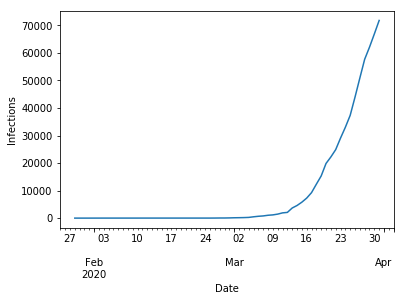

In [7]:
fig, ax = plt.subplots()
DE.loc[:,'Infected'].iloc[1:].plot()
ax.set_ylabel('Infections')

### Plot new infections of Covid 19 in Germany

Text(0,0.5,'New infections')

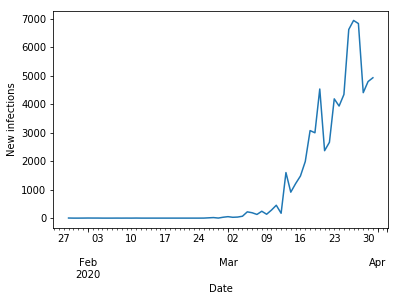

In [8]:
fig, ax = plt.subplots()
DE.loc[:,'Infected'].diff().iloc[1:].plot()
ax.set_ylabel('New infections')

### Plot log of growth rate of Covid 19 in Germany

Text(0,0.5,'New_Infections')

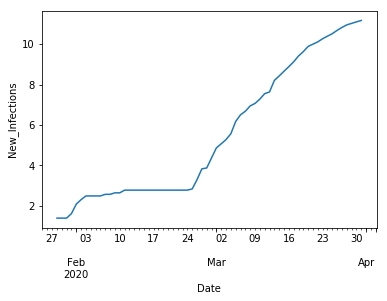

In [9]:
fig, ax = plt.subplots()
np.log(DE.loc[:,'Infected']).iloc[1:].plot()
ax.set_ylabel('New_Infections')


### Analyse the stationarity of the time series 

In [10]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print('AdFuller:',adfuller(np.log(DE.loc[:,'Infected']).diff()[1:])[1])
print('KPSS:',kpss(np.log(DE.loc[:,'Infected']).diff()[1:])[1])

AdFuller: 0.10056215521676809
KPSS: 0.1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Indicates AR 1 Process


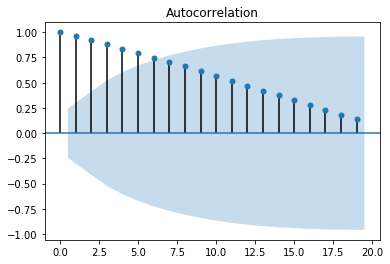

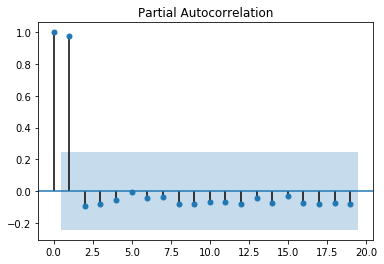

In [11]:
plot_acf(np.log(DE.loc[:,'Infected'])[1:])
plot_pacf(np.log(DE.loc[:,'Infected'])[1:])
print('Indicates AR 1 Process')

### Fit ARIMA model with Auto ARIMA 

In [12]:
from statsmodels.tools import eval_measures
from pyramid.arima import auto_arima
stepwise_model = auto_arima(np.log(DE.loc[:,'Infected'])[1:], start_p=0, start_q=0,
                           max_p=1, max_q=1, m=1,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Fit ARIMA: order=(0, 1, 0); AIC=-46.829, BIC=-42.542, Fit time=0.042 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-62.173, BIC=-55.744, Fit time=0.053 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-58.348, BIC=-51.919, Fit time=0.041 seconds
Fit ARIMA: order=(1, 1, 1); AIC=-63.289, BIC=-54.717, Fit time=0.089 seconds
Total fit time: 0.226 seconds
-63.28924256718767


### Forecasting 

In [13]:
train = pd.Series(np.log(DE.loc[:,'Infected'])[1:-3])
test = pd.Series(np.log(DE.loc[:,'Infected'])[-3:])
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=3)
#Back transformation
train, test, future_forecast = np.exp(train), np.exp(test) , np.exp(future_forecast)
ARIMA_RMSE = eval_measures.rmse(test, future_forecast)
print('Root Mean Squared Error:',ARIMA_RMSE)

Root Mean Squared Error: 11626.89526665678


In [14]:
future_forecast = pd.Series(future_forecast, index= test.index)
test_series = train.append(test)
forecast_series = train.append(future_forecast)

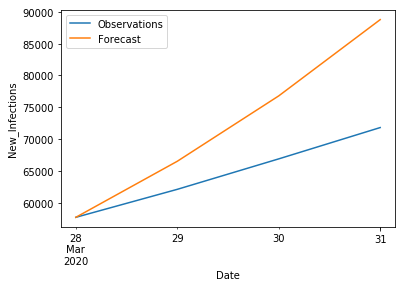

In [15]:
fig, ax = plt.subplots()
test_series.iloc[-4:].plot()
forecast_series.iloc[-4:].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

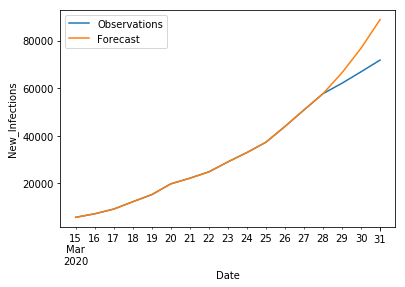

In [16]:
fig, ax = plt.subplots()
test_series.loc['2020-03-15':].plot()
forecast_series.loc['2020-03-15':].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

## Fit dynamic linear model 

In [143]:
from pydlm import dlm, trend, dynamic, autoReg
dm = dlm(DE.loc[:,'Infected']) + trend(degree=2, discount=0.95, name='quad')
dm = dm + autoReg(degree=1, discount=0.95, name='AR1', w=1e7)
dm.fitForwardFilter()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


## Forecasting with KalmanFilter 

In [144]:
KLpredict,pred_var = dm.predictN(N=3,date=dm.n - 3 )
next_day,_ = dm.predict()
print('Next day prediction:', next_day)

Next day prediction: [[76891.26841237]]


In [145]:
#Calculate the standard deviation
MSE = dm.getMSE()
print('Kalman RMSE:',np.sqrt(MSE))
print('ARIMA RMSE:',ARIMA_RMSE)

Kalman RMSE: 670.1718459694886
ARIMA RMSE: 11626.89526665678


In [146]:
KLpredict = pd.Series(KLpredict, index= test.index)
test_series = train.append(test)
forecast_series = train.append(KLpredict)

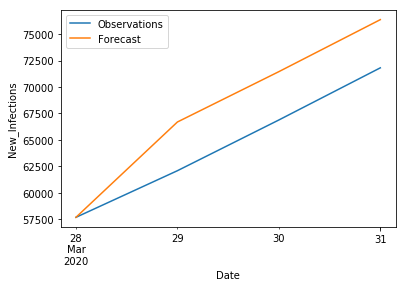

In [147]:
fig, ax = plt.subplots()
test_series.iloc[-4:].plot()
forecast_series.iloc[-4:].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

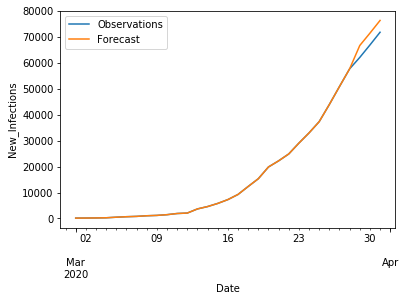

In [149]:
fig, ax = plt.subplots()
test_series.loc['2020-03-01':].plot()
forecast_series.loc['2020-03-01':].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

### Get weather data

In [24]:
from wwo_hist import retrieve_hist_data
frequency = 24
start_date = '22-JAN-2020'
end_date = '28-MAR-2020'
api_key = 'f2c76ab75910443592c104308202903'

In [26]:
# Germany
location_list = ['Germany']
os.chdir("../Data/weather/germany")

hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True)




Retrieving weather data for Germany


Currently retrieving data for Germany: from 2020-01-22 to 2020-01-31
Time elapsed (hh:mm:ss.ms) 0:00:00.482563
Currently retrieving data for Germany: from 2020-02-01 to 2020-02-29
Time elapsed (hh:mm:ss.ms) 0:00:01.343875
Currently retrieving data for Germany: from 2020-03-01 to 2020-03-28
Time elapsed (hh:mm:ss.ms) 0:00:02.267590


export Germany completed!




In [41]:
# Get Italian data
DE = country_filter(data, Country='Germany')
IT = country_filter(data, Country='Italy')
#IT = find_timepoint_zero(IT)
#IT = IT[IT.Timepoint != -1]

Text(0,0.5,'Infections')

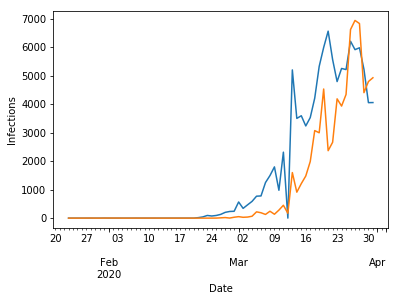

In [56]:
fig, ax = plt.subplots()
IT.loc[:,'Infected'].diff().iloc[1:].plot()
DE.loc[:,'Infected'].diff().iloc[1:].plot()
ax.set_ylabel('Infections')

In [50]:
from scipy import signal
cc_func = pd.Series(np.correlate(DE.loc[:,'Infected'].iloc[1:],IT.loc[:,'Infected'].iloc[1:], mode='full'), index= IT.loc[:,'Infected'].iloc[1:].index)

ValueError: Wrong number of items passed 137, placement implies 69

Text(0,0.5,'Correlation')

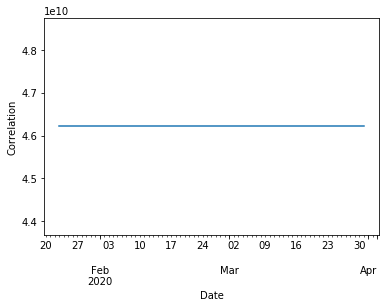

In [49]:
fig, ax = plt.subplots()
cc_func.plot()
ax.set_ylabel('Correlation')

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.28025237, 0.32420501, 0.38192604, 0.42518361, 0.47992516,
        0.55279306, 0.63568333, 0.72637814, 0.79464442, 0.86036649,
        0.91835656, 0.89634488, 0.89640743, 0.86761761, 0.84574292,
        0.82395518, 0.78128794, 0.7514487 , 0.67749054, 0.64811929,
        0.59473741]),
 <matplotlib.lines.Line2D at 0x119bda7b8>)

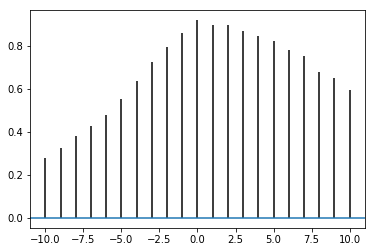

In [58]:
from matplotlib import pyplot
pyplot.xcorr(DE.loc[:,'Infected'].diff().iloc[1:],IT.loc[:,'Infected'].diff().iloc[1:])

In [51]:
len(DE.loc[:,'Infected'].iloc[1:])

69

In [27]:
weather = pd.read_csv("../Data/weather/germany/Germany.csv")


FileNotFoundError: File b'../Data/weather/germany/Germany.csv' does not exist

### Read socio economical features 

In [22]:
import pandas as pd
import os 

os.chdir('/Users/matthiasboeker/Desktop/Covid_19_Forecast/Data')
data_files = []
for file in os.listdir():
    if file.endswith('.csv'):
        data_files.append(file)
        #data_list = data_list
features=[]
for i in range(0,len(data_files)):        
    d = pd.read_csv(data_files[i], sep=',', skiprows=3, encoding= 'unicode_escape')
    d.index = d.loc[:,'Region']
    d = d.loc[:,'2018']
    d = d.rename(data_files[i][:-4])
    cut = 1
    if len(d)>32:
        cut = (len(d)-32)+1
    d= d.iloc[:-cut]
    features.append(d)
    
feature_space = pd.DataFrame(features).T

In [23]:
print('Targets Index',len(target.index))
print('Features Index',len(feature_space.index))
target = target.drop(target.index[~np.isin(target.index,feature_space.index)].values)
feature_space = feature_space.drop('Passenger_National_Railroad',axis=1)

Targets Index 33
Features Index 31


In [24]:
feature_space['Urban_Ratio'] = feature_space['Urban_Res']/feature_space['Rural_Res']
feature_space = feature_space.drop(['Urban_Res','Rural_Res'],axis=1)
feature_space['Students'] = feature_space['Students_high']+feature_space['Students_primary']+feature_space['Students_Secondary']
feature_space = feature_space.drop(['Students_high','Students_primary','Students_Secondary'],axis=1)
feature_space['Perc_Gen_Hospitals'] = feature_space['Number_general_hospitals']/feature_space['Number_health_inst']

### Analyse the correlation of the feature space

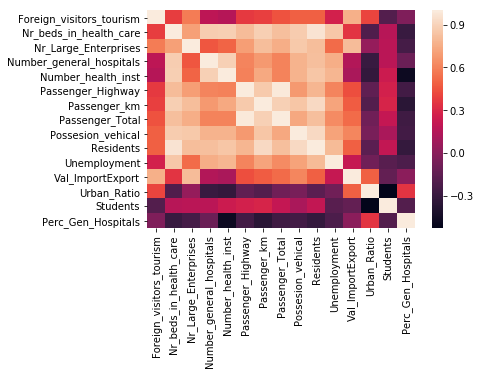

In [25]:
import seaborn as sn
corr = feature_space.corr()
sn.heatmap(corr, annot=False)

plt.show()

In [26]:
feature_space = feature_space.drop(['Number_general_hospitals','Number_health_inst','Nr_beds_in_health_care',
                                   'Nr_Large_Enterprises','Possesion_vehical',
                                   'Passenger_km','Passenger_Total','Passenger_Highway','Foreign_visitors_tourism',
                                   'Perc_Gen_Hospitals','Residents','Val_ImportExport','Students'],axis=1)

In [21]:
params = list()
missing_states = list()
for state in state_list:
    y = CH.loc[CH['Province/State']==state,'Infected'].transform(lambda x: x*(100/x.max()))
    x = np.array(range(0,len(y)),dtype=float)
    try:
        new_params = np.polyfit(x,y, deg=3)
        params.append(new_params)
    except:
        print('Couldnt fit:',state)
        missing_states.append(state)        
fit_state = state_list.loc[~np.isin(state_list,missing_states)]
target = pd.DataFrame(params, columns=['x3', 'x2', 'x1', 'c',], index = fit_state)    
        

In [27]:
feature_space = feature_space.sort_index()
target = target.sort_index()

### Fit first linear regression for socio econ variables

In [272]:
import statsmodels.api as sm
mod = sm.GLS(target['x3'], feature_space)
res = mod.fit()
print(res.summary())

                                 GLS Regression Results                                
Dep. Variable:                     x3   R-squared (uncentered):                   0.607
Model:                            GLS   Adj. R-squared (uncentered):              0.580
Method:                 Least Squares   F-statistic:                              22.42
Date:                Sat, 28 Mar 2020   Prob (F-statistic):                    1.30e-06
Time:                        21:36:42   Log-Likelihood:                          181.25
No. Observations:                  31   AIC:                                     -358.5
Df Residuals:                      29   BIC:                                     -355.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

# Model growth rate of Covid 19 in China 
## Fit polynom and extract parameters

In [139]:
#Get the Data 
CH = country_filter(data, Country='China')
state_list = CH['Province/State'].drop_duplicates()

### Example: Fit polynom to data in Zhejiang 

In [140]:
y = np.array(CH.loc[CH['Province/State']=='Zhejiang','Infected'].transform(lambda x: x*(100/x.max())))
x = np.array(range(0,len(y)),dtype=float)
#params,_ = fit(logistic,x,y)
params = np.polyfit(x,y, deg=3)
p = np.poly1d(params)
print(params)

[ 1.28997901e-03 -1.78284022e-01  7.87153440e+00 -1.31450134e+01]


Text(0,0.5,'Number of Infections in %')

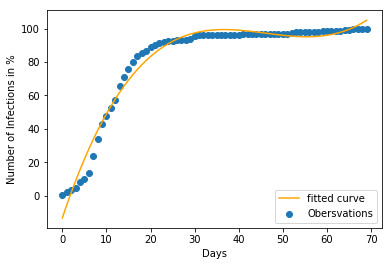

In [141]:
fig, axes = plt.subplots()
plt.scatter(x,y)
plt.plot(x,p(x),color='orange')
#plt.plot(x,logistic(x,params[0],params[1],params[2],params[3],params[4]),color='orange')
axes.legend(['fitted curve','Obersvations'])
axes.set_xlabel('Days')
axes.set_ylabel('Number of Infections in %')